In [65]:
#!/usr/bin/env python3

# MIT License

# Copyright (c) 2024 Derek King

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.


# Code based on PyTorch tutorial on transfer learning : https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
# Original License: BSD
# Original Author: Sasank Chilamkurthy

from collections import defaultdict
import copy
import matplotlib.pyplot as plt
import numpy as np
import os.path
import random
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from typing import Iterator, List
from label_pair_sampler import LabelPairSampler

project_dir = '/home/dking/data/nn_corners'
data_dir = os.path.join(project_dir, 'out_data3')

plt.ion()   # interactive mode

In [66]:
# Data augmentation and normalization for training
# Just normalization for validation

color_mean = [0.485, 0.456, 0.406]
color_stddev = [0.229, 0.224, 0.225]

# TODO use v2
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(10.0),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.2), ratio=(0.95, 1.05)),
        # TODO color shifting (a little bit)
        #transforms.RandomHorizontalFlip(),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(color_mean, color_stddev)
    ]),
    'val': transforms.Compose([
        #transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(color_mean, color_stddev)
    ]),
}

image_datasets = {}
dataloaders = {}
for x in ['train', 'val']:
    dataset = datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    sampler = LabelPairSampler(dataset, batch_size=8)
    dataloader = torch.utils.data.DataLoader(dataset, batch_sampler=sampler, num_workers=4)
    image_datasets[x] = dataset
    dataloaders[x] = dataloader
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

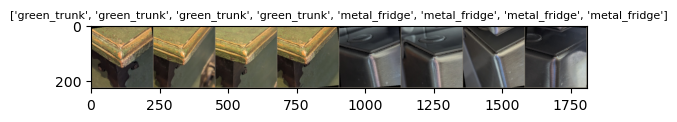

In [35]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.array(color_stddev) * inp + np.array(color_mean)
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title, fontsize = 8)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [60]:
def eval_model(model, phase):
    # evaluate how well each descriptor matches its label's output
    model.eval()
    label_stats = {}
    with torch.no_grad():
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)
            descriptors = torch.sigmoid(model(inputs))
            for d, l in zip(descriptors, labels):
                l = l.item()
                if l not in label_stats:
                    label_stats[l] = [d, 1]
                else:
                    label_stats[l][0] += d
                    label_stats[l][1] += 1
        label_avgs = {label:(sum/cnt) for label, (sum, cnt) in label_stats.items()}

        failures = defaultdict(int)
        epoch_acc = 0
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)
            descriptors = torch.sigmoid(model(inputs))
            for d, l in zip(descriptors, labels):
                l = l.item()
                best_diff = float("+inf")
                best_label = None
                for l2, avg in label_avgs.items():
                    diff = torch.sum(torch.pow(d - avg, 2)).item()
                    if diff < best_diff:
                        best_diff = diff
                        best_label = l2
                if l == best_label:
                    epoch_acc += 1
                else:
                    failures[(l, best_label)] += 1
    epoch_acc /= dataset_sizes[phase]
    return epoch_acc, failures


def summarize_eval_results(model):
    for phase in ('train', 'val'):
        epoch_acc, failures = eval_model(model, phase)
        print(f'{phase} Acc: {epoch_acc:.4f}')
        if len(failures):
            ordered_failures = [(count, true_label, best_label) for (true_label, best_label), count in failures.items()]
            ordered_failures.sort(reverse=True)
            print("  Top 10 failures:")
            for (count, true_label, best_label) in ordered_failures[:10]:
                print(f"    {count}x : expected '{class_names[true_label]}' got '{class_names[best_label]}'")
        else:
            print("  No failures")


def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    start_time = time.time()
    best_acc_loss = (0.0, float('+inf'))
    best_model_state_dict = copy.deepcopy(model.state_dict())
    init_model_state_dict = copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        epoch_acc_sum = 0.0
        epoch_loss_sum = 0.0

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc, _ = eval_model(model, phase)
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            epoch_acc_sum += epoch_acc
            epoch_loss_sum += epoch_loss

        # make copy of best iteration model 
        assert phase == 'val'
        epoch_acc_loss = (epoch_acc_sum/2, -epoch_loss_sum/2)
        if epoch_acc_loss > best_acc_loss:
            best_acc_loss = epoch_acc_loss
            best_model_state_dict = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - start_time
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best : Avg Acc: {best_acc_loss[0]:4f}  Avg Loss: {-best_acc_loss[1]:4f}')
    print()

    print("Best Model")
    model.load_state_dict(best_model_state_dict)
    summarize_eval_results(model)
    print()

    return model

In [61]:
model = torchvision.models.resnet18(weights='IMAGENET1K_V1')

for param in model.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model.fc.in_features
descriptor_ftrs = 3
model.fc = nn.Linear(num_ftrs, descriptor_ftrs)
model = model.to(device)

def criterion(output, target):
    loss = torch.tensor(0.0, requires_grad=True)
    # can't compute loss on just batch of just 1 sample because loss
    # computed by comparing outputs between different labels
    if len(output) <= 1:
        return loss

    descriptors = torch.sigmoid(output)
    for i in range(len(output)):
        for j in range(i+1, len(output)):
            diff = torch.sum(torch.pow(descriptors[i] - descriptors[j], 2))
            #print(f"{i} {j} : {diff}")
            if target[i] == target[j]:
                loss = loss + diff
            else:
                # having two descriptors for different for different labels
                # is less important (and gets less weight) that having
                # to matching labels have the same value
                loss = loss - 0.1 * diff
    count = (len(output) * (len(output) - 1))//2
    loss = loss / count
    return loss

# Observe that only parameters of final layer are being optimized as
# opposed to before.
#optimizer = optim.SGD(model.fc.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(model.fc.parameters())

# Decay LR by half every 5 epochs
#scheduler = torch.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Effectively don't change learning rate
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=1.0)

In [62]:
model = train_model(model, criterion, optimizer, scheduler, num_epochs=20)

Epoch 0/19
----------


train Loss: 0.0085 Acc: 0.8222
val Loss: -0.0016 Acc: 0.7333

Epoch 1/19
----------
train Loss: 0.0010 Acc: 0.9556
val Loss: -0.0067 Acc: 0.7333

Epoch 2/19
----------
train Loss: -0.0056 Acc: 1.0000
val Loss: -0.0127 Acc: 1.0000

Epoch 3/19
----------
train Loss: -0.0085 Acc: 1.0000
val Loss: -0.0244 Acc: 1.0000

Epoch 4/19
----------
train Loss: -0.0233 Acc: 1.0000
val Loss: -0.0315 Acc: 1.0000

Epoch 5/19
----------
train Loss: -0.0320 Acc: 1.0000
val Loss: -0.0436 Acc: 1.0000

Epoch 6/19
----------
train Loss: -0.0373 Acc: 1.0000
val Loss: -0.0538 Acc: 1.0000

Epoch 7/19
----------
train Loss: -0.0419 Acc: 1.0000
val Loss: -0.0627 Acc: 1.0000

Epoch 8/19
----------
train Loss: -0.0425 Acc: 1.0000
val Loss: -0.0675 Acc: 1.0000

Epoch 9/19
----------
train Loss: -0.0671 Acc: 1.0000
val Loss: -0.0699 Acc: 1.0000

Epoch 10/19
----------
train Loss: -0.0688 Acc: 1.0000
val Loss: -0.0765 Acc: 1.0000

Epoch 11/19
----------
train Loss: -0.0457 Acc: 1.0000
val Loss: -0.0812 Acc: 1.0000

Ep

In [67]:
params_path = os.path.join(project_dir, 'nn_corner_params.pt')
torch.save(model.state_dict(), params_path)


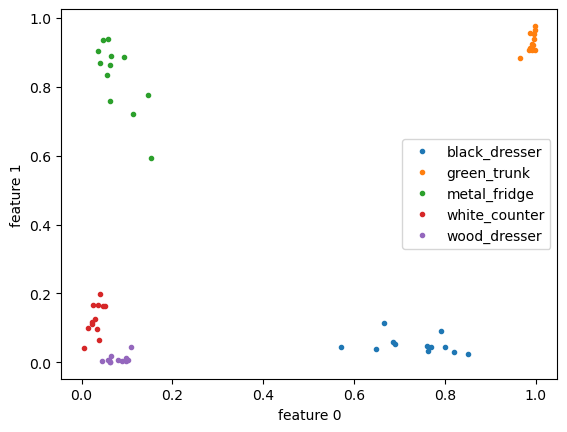

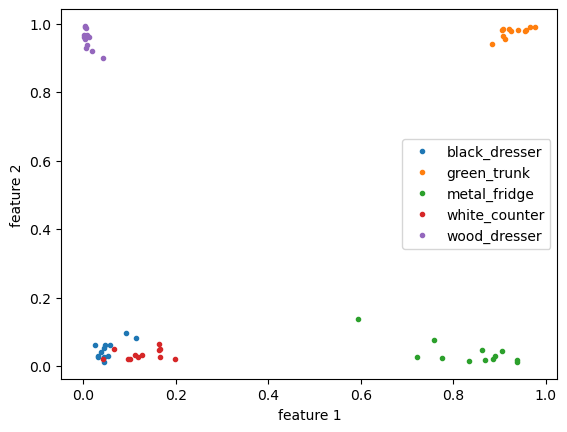

In [75]:
def visualize_descriptors(model):
    # evaluate how well each descriptor matches its label's output
    model.eval()
    label_descriptors = defaultdict(list)
    
    # Evaluate label descriptors for both training and testing data
    for phase in ('train', 'val'):
        with torch.no_grad():
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                descriptors = torch.sigmoid(model(inputs))
                for d, l in zip(descriptors, labels):
                    label_descriptors[l.item()].append(d.cpu())

    # make a number of 2D plots of different 'feature' from descriptor vector
    ordered_labels = sorted(list(label_descriptors.keys()))
    for ftr_idx in range(1, descriptor_ftrs):
        plt.figure(f"feature {ftr_idx-1} and {ftr_idx}")
        for label in ordered_labels:
            x = [d[ftr_idx-1] for d in label_descriptors[label]]
            y = [d[ftr_idx] for d in label_descriptors[label]]
            plt.plot(x, y, '.', label=class_names[label])
        plt.legend(loc='best')
        plt.xlabel(f"feature {ftr_idx-1}")
        plt.ylabel(f"feature {ftr_idx}")
    plt.pause(0.001)  # pause a bit so that plots are updated

visualize_descriptors(model)